# Example to visualize time-series data
This notebook analysis signal data over time that has been collected on different instruments containing flashing lamps to measure the signal data. The signal data uses `discrete` or `continuous` scheme on the flashing lamps, which may affect the time-series pattern because of the different signal processing used. The objective is to analyse the impact that the instruments and flashing scheme have on the signal data.

It is used a synthetic dataset stored on the `singal_sample_data.csv` file with the following field description:
 - `run_key` - uuid to identify a specific run
 - `instrument` - name of the instrument as `stringType`
 - `scheme` - flashing scheme that can be only `discrete` or `continuous`
 - `pass_no` - pass number as `integerType`, starts at 1
 - `flash_no` - flash number as `integerType`, starts at 1
 - `time_float` - time in min when signal was measured
 - `signal` - signal value

---
## Import packages
Let us import `pandas` to read the csv-file as DataFrame and `matplotlib`, `seaborn`, `plotly` for data visualization.

In [46]:
from typing import Dict, List
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo

## Read `signal_sample_data.csv` file

In [29]:
df = pd.read_csv('Data/signal_sample_data.csv')

display(df.head(10))

,run_key,run_no,instrument,scheme,pass_no,flash_no,time_float,signal
0,0234-asd,1,i10,discrete,1,1,5.146601,0.253363
1,0234-asd,1,i10,discrete,1,2,5.140924,0.217533
2,0234-asd,1,i10,discrete,1,3,5.120772,0.266665
3,0234-asd,1,i10,discrete,2,1,6.237628,0.424502
4,0234-asd,1,i10,discrete,2,2,6.270189,0.428470
5,0234-asd,1,i10,discrete,2,3,6.213320,0.436210
6,0234-asd,1,i10,discrete,3,1,7.638489,0.632309
7,0234-asd,1,i10,discrete,3,2,7.685132,0.619283
8,0234-asd,1,i10,discrete,3,3,7.692587,0.658963
9,0sde-478,2,i10,discrete,1,1,5.117380,0.233197


In [30]:
df.dtypes

run_key        object
run_no          int64
instrument     object
scheme         object
pass_no         int64
flash_no        int64
time_float    float64
signal        float64
dtype: object

### Quick data analysis
 - Count the number of `pass_no x flash_no` per `run_key`
 - Describe on the `time_float` and `signal`

In [31]:
df.groupby(by=['run_key', 'instrument', 'scheme'])['pass_no'].count()

run_key                           instrument  scheme    
0234-asd                          i10         discrete       9
02DCA379-063D-DDE1-EE5E-496ECE79  i11         continuous    18
0sde-478                          i10         discrete       9
1ABA9CD9-A61D-9EC0-462A-BBA1E600  i11         continuous    18
23d-fere                          i11         discrete       9
25DAD5D7-BC93-18CC-D040-B505C988  i10         continuous    18
55308D3E-223A-19D8-045C-84329685  i10         continuous    18
858E56BF-FCD7-4277-45F5-F16F7633  i10         continuous    18
DC8BD0A9-0B5D-1AEF-AE75-B2E35B8C  i11         continuous    18
F5C26BFB-17CD-879C-06B1-22703F4E  i10         continuous    18
FBD4C3C1-8DD2-C7FF-0B40-2C3143D0  i11         continuous    18
sdas-210                          i11         discrete       9
Name: pass_no, dtype: int64

In [32]:
df.groupby(by=['instrument', 'scheme'])[['time_float', 'signal']].describe()

time_float                                          \
                           count      mean       std       min       25%   
instrument scheme                                                          
i10        continuous       72.0  6.427252  1.216158  4.069707  5.313937   
           discrete         18.0  6.340237  1.061704  5.117380  5.152298   
i11        continuous       72.0  6.517251  1.221174  4.138669  5.417916   
           discrete         18.0  6.356832  1.053199  5.125110  5.193032   

                                                    signal            \
                            50%       75%       max  count      mean   
instrument scheme                                                      
i10        continuous  6.666526  7.464387  8.253810   72.0  0.506176   
           discrete    6.218945  7.635751  7.692587   18.0  0.442294   
i11        continuous  6.788654  7.542278  8.379428   72.0  0.605277   
           discrete    6.235187  7.651436  7.685105   18.0  0.451623   

                                                                         \
                            std       min       25%       50%       75%   
instrument scheme                                                         
i10        continuous  0.130653  0.253363  0.401299  0.514667  0.595636   
           discrete    0.171246  0.205061  0.258439  0.436070  0.629052   
i11        continuous  0.142787  0.347003  0.488787  0.594810  0.711909   
           discrete    0.168265  0.208921  0.279538  0.473551  0.605028   

                                 
                            max  
instrument scheme                
i10        continuous  0.794139  
           discrete    0.674966  
i11        continuous  0.893481  
           discrete    0.676574

## Plotting time-series
First, let me create functions that are helpful to generalize the plotting
 - `group_time_series`: groups the time-series into dictionary to better organize the plotting
 - `aggregate_time_series`: aggregates the time-series on specific columns, for example average `signal` and `time` for every `pass_no`, `flash_no`
 - `plot_time_series`: plots the time_series of the same group with the same label

In [72]:
def group_time_series(df: pd.DataFrame, join_cols: List[str]) -> Dict:
    return dict(tuple(df.groupby(join_cols)))

def aggregate_time_series(df: pd.DataFrame, group_cols: List[str], target_cols: List[str], agg_fun: str) -> pd.DataFrame:
    # Validate the aggregation function
    if agg_fun not in ['mean', 'sum', 'min', 'max', 'median', 'std', 'var', 'count']:
        raise ValueError(f"Unsupported aggregation function: {agg_fun}")
    
    # Create a dictionary to map aggregation functions to columns
    agg_dict = {col: agg_fun for col in target_cols}
    # Group by the specified columns and aggregate using the specified function
    return df.groupby(by=group_cols).agg(agg_dict).reset_index()

def plot_time_series(x: str, y: str, kind: str, plt_kwargs: Dict) -> None:
    if kind == 'matplotlib':
        if 'linestyle' in plt_kwargs:
            plt.plot(x, y, **plt_kwargs)  # Use plt.plot for line plots
        else:
            plt.scatter(x, y, **plt_kwargs)  # Use plt.scatter for scatter plots
    else:
        raise ValueError(f'Invalid plot {kind} parameter, insert "matplotlib", "plotly".')

Split the `df` into subsets based on *grouping cols* 'instrument', 'scheme'. This makes easy for us to plot the time series within the same group.

In [50]:
d_split_df = group_time_series(df=df, join_cols=['instrument', 'scheme'])

# Display for one instrument and scheme
display(d_split_df[('i10', 'discrete')])

,run_key,run_no,instrument,scheme,pass_no,flash_no,time_float,signal
0,0234-asd,1,i10,discrete,1,1,5.146601,0.253363
1,0234-asd,1,i10,discrete,1,2,5.140924,0.217533
2,0234-asd,1,i10,discrete,1,3,5.120772,0.266665
3,0234-asd,1,i10,discrete,2,1,6.237628,0.424502
4,0234-asd,1,i10,discrete,2,2,6.270189,0.428470
5,0234-asd,1,i10,discrete,2,3,6.213320,0.436210
6,0234-asd,1,i10,discrete,3,1,7.638489,0.632309
7,0234-asd,1,i10,discrete,3,2,7.685132,0.619283
8,0234-asd,1,i10,discrete,3,3,7.692587,0.658963
9,0sde-478,2,i10,discrete,1,1,5.117380,0.233197


Calculates the `mean` time-series for each group

In [56]:
d_agg_df = {}
for key, group_df in d_split_df.items():
    d_agg_df[key] = aggregate_time_series(group_df, ['pass_no', 'flash_no'], ['time_float', 'signal'], 'mean')

# Display a single dict_key
d_agg_df[('i10', 'continuous')]

,pass_no,flash_no,time_float,signal
0,1,1,4.102732,0.331772
1,2,1,4.567128,0.347109
2,3,1,4.990663,0.360592
3,4,1,5.239340,0.383854
4,5,1,5.256014,0.371221
5,6,1,5.720587,0.420705
6,7,1,5.802672,0.420707
7,8,1,6.117686,0.468247
8,9,1,6.414763,0.522964
9,10,1,6.934031,0.531049


Let us focus on a single instrument to understand how `scheme` impacts the signal data.
 - Remove the IF-condition and it plots for all instruments

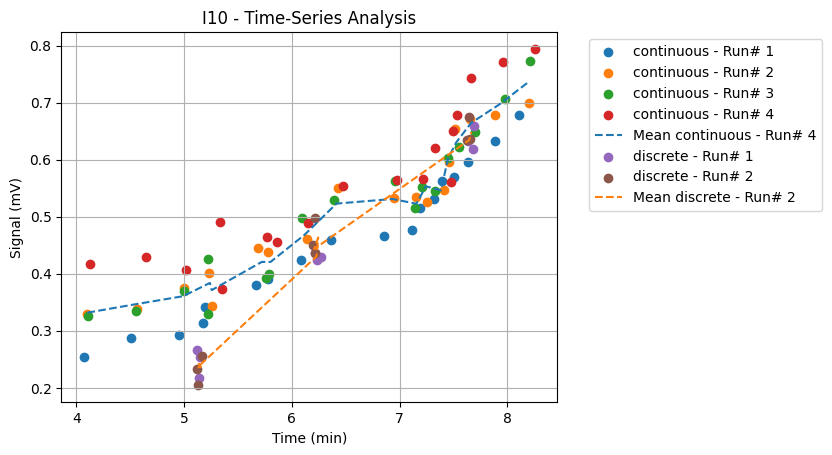

In [85]:
# Plot input
instrument = 'i10'
plot_col = 'run_no'
x_val = 'time_float'
y_val = 'signal'
x_label = 'Time (min)'
y_label = 'Signal (mV)'

# Plot individual runs for 'discrete' scheme
for key, group_df in d_split_df.items():
    if key[0] == instrument:
        for plt_idx, df_plot in group_df.groupby(plot_col):
            plot_time_series(x=df_plot[x_val], y=df_plot[y_val], kind='matplotlib', plt_kwargs={'label': f'{key[1]} - Run# {plt_idx}'})
        # Plot the mean time-series for 'discrete' scheme
        df_agg = d_agg_df.get(key)
        plot_time_series(df_agg[x_val], df_agg[y_val], kind='matplotlib', plt_kwargs={'label': f'Mean {key[1]} - Run# {plt_idx}', 'linestyle': '--'})

# Customize the plot
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(f'{instrument.upper()} - Time-Series Analysis')
plt.grid(True)

# Place the legend on the right side of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [37]:
# Create traces for individual runs (discrete)
discrete_traces = []
for run_no, group in discrete_df.groupby(['run_no']):
    discrete_traces.append(
        go.Scatter(
            x=group['time_float'],
            y=group['signal'],
            mode='markers',
            name=f'Discrete Run {run_no}',
            marker=dict(symbol='circle', size=8)
        )
    )

# Create traces for individual runs (continuous)
continuous_traces = []
for run_no, group in continuous_df.groupby(['run_no']):
    continuous_traces.append(
        go.Scatter(
            x=group['time_float'],
            y=group['signal'],
            mode='markers',
            name=f'Continuous Run {run_no}',
            marker=dict(symbol='x', size=8)
        )
    )

# Create traces for the mean time-series (discrete)
discrete_mean_trace = go.Scatter(
    x=discrete_mean['time_float'],
    y=discrete_mean['signal'],
    mode='lines',
    name='Mean (discrete)',
    line=dict(dash='dash')
)

# Create traces for the mean time-series (continuous)
continuous_mean_trace = go.Scatter(
    x=continuous_mean['time_float'],
    y=continuous_mean['signal'],
    mode='lines',
    name='Mean (continuous)',
    line=dict(dash='dash')
)

# Customize the layout
layout = go.Layout(
    xaxis=dict(title='Time'),
    yaxis=dict(title='Signal'),
    title=f'Time-Series Analysis for {instrument_name}',
    title_x=0.5,
    showlegend=True
)

# Initialize Plotly for Jupyter Notebook
pyo.init_notebook_mode(connected=True)

# Create a figure containing both sets of traces
fig = go.Figure(data=discrete_traces + continuous_traces + [discrete_mean_trace, continuous_mean_trace], layout=layout)
# Display the figure in the notebook
fig.show()